### Geospatial Analysis: Medically Underserved Areas based on Open Location Code (Multi-Class CNN-OLC Model)

1. Data was first pre-processed and load the final version of la_facility_mua.csv here

2. Since feature engineering has already been done, a few touch-ups before training:

a) Feature Mapping,

b) Dropping useless variables,

c) Regex applications,

d) Days Diff

3. Data was split into Train and Validation

4. Model: Multi-Class CNN-OLC with Tensorflow.Keras (OLC gives more granular location classification- 69 classes)

5. The best model with Train Loss: 0.5058 - Train Accuracy: 0.7876, Val Loss: 0.4752 - Val Accuracy: 0.8150

In [2]:
import os
os.environ['PYTHONHASHSEED']='0'

In [3]:
import random as rn
# Deep Learning Libraries
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.layers import Conv1D,MaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import callbacks
import tensorflow as tf
np.random.seed(37)
rn.seed(42)
tf.random.set_seed(42)
from keras import backend as K

Using TensorFlow backend.


In [4]:
!pip install openlocationcode

  Created wheel for openlocationcode: filename=openlocationcode-1.0.1-py3-none-any.whl size=8419 sha256=67294f7d5e4e60a7615010ea30da6b04ec295ad67d83f7c38227cf21ea0df91f
  Stored in directory: /root/.cache/pip/wheels/22/35/e2/e8522d642672138ffd5f7773236a5de74ceb22c99d78d9c866
Successfully built openlocationcode


In [5]:
#1
import pandas as pd
import numpy as np
import seaborn as sns
import re
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.gridspec as gridspec
import geopandas
from geopandas import GeoDataFrame
from shapely.geometry import Point
import pyproj
from openlocationcode.openlocationcode import *
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc,roc_auc_score
from catboost import CatBoostClassifier,Pool, cv
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold

la_facility_mua = pd.read_csv('../input/la-final-data-2/la_facility_mua.csv')

In [6]:
#2
la_facility_mua.head(6)

,source,cat1,cat2,org_name,Name,addrln1,city,state,post_id,description,...,facility_address_1,MUA_RuralStatus,MUA_Designated_Time,MUA_Designated_Date,MUA_MSSA_Name_1,MUA_Updated_Time,MUA_Updated_Date,MUA_Poverty,MUA_Score,MUA_Pct_100Poverty
0,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,415 South Union Avenue,Urban,1.067990e+12,2003-11-05,MSSA 78.2b (Pico Union/Westlake),1.067990e+12,2003-11-05,157757.0,51.0,0.0
1,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,600 St Paul Ave,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
2,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1125 W 6th St,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
3,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1225 Wilshire Boulevard,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
4,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1127 Wilshire Blvd,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0
5,211,Social Services,Children and Family Services,neweconomicsforwomen.org,New Economics For Women - Familysource Center ...,501 S. Bixel St.,Los Angeles,CA,56652,The agency is an economic development organiza...,...,1212 Wilshire Blvd,Urban,7.686144e+11,1994-05-11,Westlake Service Area,1.005782e+12,2001-11-15,0.0,60.1,0.0


In [7]:
#3
la_facility_mua=la_facility_mua[la_facility_mua['MUA_Designated_Time'].notnull()]
la_facility_mua.drop(['facility_number_of_beds', 'facility_name', 'org_name', 'Name'],
                    axis=1, inplace=True)
la_facility_mua= la_facility_mua[la_facility_mua['Zip Code']!=0.0]
la_facility_mua['Zip Code']=la_facility_mua['Zip Code'].astype('int64')

In [11]:
#7
la_facility_mua['facility_er_service'] = la_facility_mua['facility_er_service'].map({
'Not Applicable':'Not Applicable',
'None':'Not Applicable',
'Emergency - Basic':'Emergency',
'Emergency - Comprehensive':'Emergency',
'Emergency - Standby':'Emergency'
})

In [12]:
#8
la_facility_mua['MUA_Poverty']=la_facility_mua['MUA_Poverty'].map({
157757.0:2,
129447.0:1,
0.0:0,
})

In [13]:
#9
la_facility_mua['cat1+2'] = la_facility_mua['cat2'].astype('str')+'_'+la_facility_mua['cat1'].astype('str')

la_facility_mua['city'] = la_facility_mua['city'].str.replace('Signal Hill ', 'Signal Hill')
la_facility_mua['city'] = la_facility_mua['city'].str.replace(' Hollywoo', ' Hollywood').str.replace(' Hollywoodd', ' Hollywood')
la_facility_mua['city'] = la_facility_mua['city'].str.replace('Los Angeles,', 'Los Angeles').str.replace('Los Angeles ', 'Los Angeles').str.replace('Los Angelels','Los Angeles').str.replace('Los  Angeles', 'Los Angeles').str.replace(' Los Angeles', 'Los Angeles')
la_facility_mua['city'] = la_facility_mua['city'].str.replace('Industry', 'City of Industry').str.replace('City of Industry ', 'City of Industry').str.replace('City of City of Industry', 'City of Industry')
la_facility_mua['city'] = la_facility_mua['city'].str.replace('Bell', 'Bell Gardens').str.replace('Bell Gardensflower', 'Bell Gardens').str.replace('Bell Gardens Gardens', 'Bell Gardens')

In [15]:
#11
la_facility_mua['Address'] = la_facility_mua['facility_address_1'].str.lower()
la_facility_mua['Street'] = la_facility_mua['Address'].str.extract('([a-zA-Z ]+)', expand=False).str.strip()

la_facility_mua['Street'] = la_facility_mua['Street'].str.replace(' boulevard', ' blvd').str.replace(' place',' pl').str.replace(' avenue',' ave').str.replace(' street',' st').str.replace(' highway',' hwy').str.replace(' road',' rd').str.replace(' drive',' dr').str.replace(' huntington drive south', ' south huntington dr').str.replace(' huntington dr n', ' north huntington dr').str.replace('south ', 's ').str.replace('north ','n ').str.replace('east ','e ').str.replace('west ','w ').str.replace('south','s').str.replace('north','n').str.replace('east','e').str.replace('west','w')

In [17]:
#14
la_facility_mua['MUA_Designated_Date'] = pd.to_datetime(la_facility_mua['MUA_Designated_Date']) 
la_facility_mua['MUA_Updated_Date'] = pd.to_datetime(la_facility_mua['MUA_Updated_Date']) 
la_facility_mua['Date Difference'] = la_facility_mua['MUA_Updated_Date']-la_facility_mua['MUA_Designated_Date']

In [18]:
#15
def ddiff2days(ddiff):
    if not pd.isnull(ddiff):
        return pd.Timedelta.total_seconds(ddiff)/(24.*3600)
    else:
        return np.NaN

In [19]:
#16
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].apply(ddiff2days)
la_facility_mua['Date Difference']=la_facility_mua['Date Difference'].astype('int32')

In [20]:
#17
la_facility_mua['design_year'] = (la_facility_mua['MUA_Designated_Date'].dt.year).astype('int32')
la_facility_mua['design_month'] = (la_facility_mua['MUA_Designated_Date'].dt.month).astype('int32')
la_facility_mua['design_week'] = (la_facility_mua['MUA_Designated_Date'].dt.week).astype('int32')
la_facility_mua['design_dow'] = (la_facility_mua['MUA_Designated_Date'].dt.dayofweek).astype('int32')

la_facility_mua['update_year'] = (la_facility_mua['MUA_Updated_Date'].dt.year).astype('int32')
la_facility_mua['update_month'] = (la_facility_mua['MUA_Updated_Date'].dt.month).astype('int32')
la_facility_mua['update_week'] = (la_facility_mua['MUA_Updated_Date'].dt.week).astype('int32')
la_facility_mua['update_dow'] = (la_facility_mua['MUA_Updated_Date'].dt.dayofweek).astype('int32')

In [24]:
#13 #69-OLC #51-ZipCode
la_facility_mua['OLC'] = la_facility_mua[["latitude", "longitude"]].apply(lambda l: encode(l[0], l[1], codeLength=6), axis = 1)
la_facility_mua['OLC']=la_facility_mua['OLC'].astype('object')

In [33]:
#24
la_facility_mua.drop([
                      'MUA_Designated_Date', 'MUA_Updated_Date',
                      'latitude', 'longitude', 'facility_address_1'
                      
 ], axis=1, inplace=True)

In [34]:
cols = [c for c in la_facility_mua.columns if la_facility_mua[c].dtypes=='object']
for c in cols:
    le = LabelEncoder()
    la_facility_mua[c] = (le.fit_transform(la_facility_mua[c])).astype('int32')

In [35]:
X = la_facility_mua.drop(labels=['OLC'], axis=1)
y = la_facility_mua['OLC'].values

from sklearn.model_selection import train_test_split
X_train, X_cv, y_train, y_cv = train_test_split(X, y, test_size=0.25, random_state=tf.random.set_seed(42))

In [36]:
X_train = X_train.to_numpy()
X_cv = X_cv.to_numpy()

In [37]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
X_cv = X_cv.reshape(X_cv.shape[0],X_cv.shape[1],1)

In [38]:
# Convolutional Neural Networks (CNN)
epoch = 200
model = Sequential()
model.add(Conv1D(100,2,activation='relu',kernel_initializer='he_normal',input_shape = X_train[0].shape))
model.add(Conv1D(100,2,activation='relu', kernel_initializer='he_normal'))
model.add(Conv1D(80,2,activation='relu', kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(80,activation='relu', kernel_initializer='he_normal'))
model.add(Dense(69,activation='softmax'))

In [39]:
model.compile(optimizer=Adam(lr=0.005), loss = 'sparse_categorical_crossentropy', 
              metrics=['accuracy'])

In [40]:
earlystop = EarlyStopping(patience=20) 
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            factor=0.96, 
                                            min_lr=0.00001)
checkpointer = ModelCheckpoint(filepath='CNN_model_OLC.h5', monitor='val_accuracy', verbose=1, 
                save_best_only=True, mode='max', period=1)
callbacks = [#earlystop, 
             learning_rate_reduction, checkpointer
            ]

In [41]:
history = model.fit(X_train, y_train, epochs=epoch, 
                    validation_data=(X_cv, y_cv), 
                    callbacks=callbacks,
                    verbose=1)

Train on 7878 samples, validate on 2627 samples
Epoch 1/200
7808/7878 [============================>.] - ETA: 0s - loss: 2.4234 - accuracy: 0.3562
Epoch 00001: val_accuracy improved from -inf to 0.47278, saving model to CNN_model_OLC.h5
7878/7878 [==============================] - 8s 1ms/sample - loss: 2.4165 - accuracy: 0.3569 - val_loss: 1.7498 - val_accuracy: 0.4728
Epoch 2/200
7872/7878 [============================>.] - ETA: 0s - loss: 1.8138 - accuracy: 0.4454
Epoch 00002: val_accuracy improved from 0.47278 to 0.47545, saving model to CNN_model_OLC.h5
7878/7878 [==============================] - 6s 813us/sample - loss: 1.8131 - accuracy: 0.4458 - val_loss: 1.7904 - val_accuracy: 0.4754
Epoch 3/200
7872/7878 [============================>.] - ETA: 0s - loss: 1.6330 - accuracy: 0.4798
Epoch 00003: val_accuracy improved from 0.47545 to 0.53064, saving model to CNN_model_OLC.h5
7878/7878 [==============================] - 6s 803us/sample - loss: 1.6327 - accuracy: 0.4797 - val_loss: 

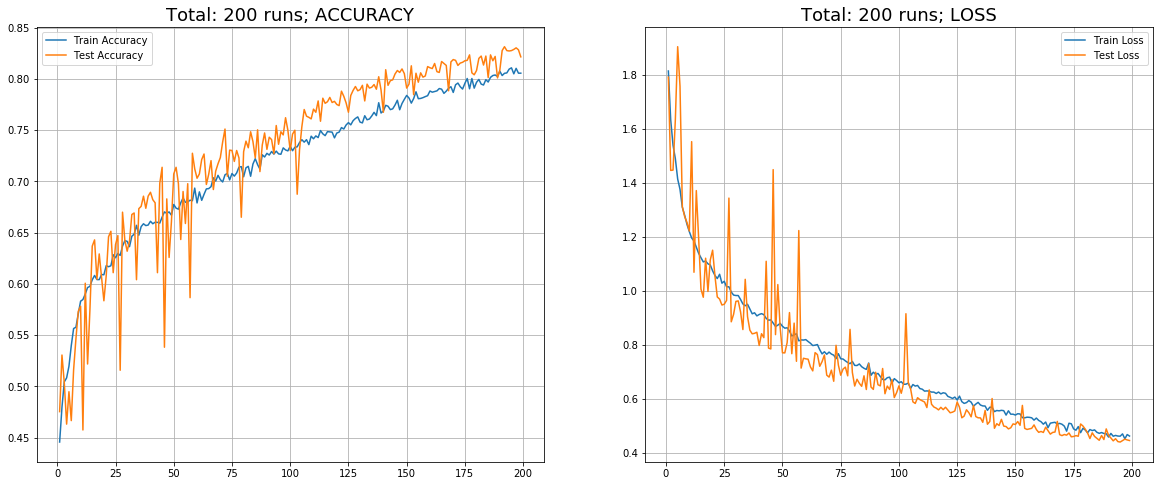

In [42]:
def plot_acc_loss(history, epochs):
    acc = history.history['accuracy']
    loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    plt.figure(figsize=(20, 8))
    plt.subplot(121)
    plt.plot(range(1,epochs), acc[1:], label='Train Accuracy')
    plt.plot(range(1,epochs), val_acc[1:], label='Test Accuracy')
    plt.title('Total: ' + str(epochs) + ' runs; '+'ACCURACY', size=18)
    plt.legend()
    plt.grid(True)
    plt.subplot(122)
    plt.plot(range(1,epochs), loss[1:], label='Train Loss')
    plt.plot(range(1,epochs), val_loss[1:], label='Test Loss')
    plt.title('Total: ' + str(epochs) + ' runs; '+'LOSS', size=18)
    plt.legend()
    plt.grid(True)
    plt.show()
    
plot_acc_loss(history, 200)